In [1]:
from PIL import Image
import numpy as np
import os, glob, itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.models import Model
from keras.models import Sequential, model_from_json
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from keras.utils import multi_gpu_model
from keras.applications.resnet50 import ResNet50
from keras import optimizers
#from keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras.applications.densenet import DenseNet201
#from keras.applications.inception_v3 import InceptionV3
import csv
import cv2 as cv

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def parse_filenames(folder_name):
    files = glob.glob(os.path.join("./", folder_name, '*.tif'))
    return files

def get_data(filenames):
    # Read from CSV file, find abbreviated label (alabel) to full label (flabel) mapping
    csv_rows = []
    with open("PLANTS.csv", 'rtU') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',', dialect=csv.excel_tab)
        for row in csvreader:
            csv_rows.append(row)

    for col_idx, col_title in enumerate(csv_rows[1]):
        if "PLPRMFL" in col_title:
            abbr_idx = col_idx
        if "PLFUELCT" in col_title:
            full_idx = col_idx
        if "Imagery Status" in col_title:
            imagery_idx = col_idx

    dict_alabel_flabel = {}
    dict_flabel_id = {}
    dict_alabel_id = {}
    dict_id_flabel = {}
    flabel_id_count = 0

    # Hard-code FFBM to id 0
    ffbm = ['OIL', 'GAS', 'COAL', 'OTHF', 'BIOMASS']
    for flabel in ffbm:
        dict_flabel_id[flabel] = 0
    dict_id_flabel[0] = 'FFBM'
    flabel_id_count += 1
    
    for row in csv_rows:
        if "YES" in row[imagery_idx]:
            if row[full_idx] not in dict_flabel_id:
                dict_flabel_id[row[full_idx]] = flabel_id_count
                dict_id_flabel[flabel_id_count] = row[full_idx]
                flabel_id_count += 1
            if row[abbr_idx] not in dict_alabel_flabel:
                dict_alabel_flabel[row[abbr_idx]] = row[full_idx]
                dict_alabel_id[row[abbr_idx]] = dict_flabel_id[row[full_idx]]
    print(dict_alabel_flabel)
    print(dict_flabel_id)

    m = len(filenames)
    X = np.zeros((m, 300, 300, 3))
    Y = np.zeros((m))
    dict_id_count = {}
    dict_flabel_count = {}

    for i in range(m):
        img = Image.open(filenames[i])
        X[i] = np.array(img)[:300,:300,:3]

        alabel = filenames[i].split('_')[-1][:-4]
        if (alabel not in dict_alabel_flabel):
            print("WARNING: unseen a-label found in filename.")
        Y[i] = int(dict_alabel_id[alabel])
        if (Y[i] not in dict_id_count):
            dict_id_count[Y[i]] = 0
        dict_id_count[Y[i]] += 1
        dict_flabel_count[dict_id_flabel[Y[i]]] = dict_id_count[Y[i]]

    print(X.shape)
    print(dict_id_count)
    print(dict_flabel_count)
    print(sorted(((v,k) for k,v in dict_flabel_count.items()), reverse=True))
    print(np.histogram(Y))
    return X, Y, dict_id_flabel

def resize_image(X, size):
    X_new = np.zeros((X.shape[0], *size, 3))
    for i in range(X.shape[0]):
        X_new[i, :, :, :] = cv.resize(X[i, :, :, :], 
                                      size, interpolation=cv.INTER_LINEAR)
    return X_new

def plot_history(history):
    '''
    Plots train and val loss and accuracy given history. From: history = model.fit(...)
    '''
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    :param cm: a confusion matrix output from sklearn func, which takes on actual label and prediction
    :param classes: a list of all the labels
    :param normalize: if True, performs row normalization
    :param title: title of the plot
    :param cmap: color choices
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Power Plant Classification Confusion Matrix.png')

In [5]:
#os.chdir('drive/Colab Notebooks')
os.getcwd()

'/home/Jerry/cs231n_power_plant'

In [6]:
np.random.seed(7)

# Load images
X_raw, Y_raw, dict_id_flabel = get_data(parse_filenames(folder_name='uspp_naip_resized'))

# Resize images
#X = resize_image(X_raw, size=(300, 300))
X = X_raw

# Convert labels into one-hot-encoding format
encoder = LabelBinarizer()
Y = encoder.fit_transform(Y_raw)

# Split into train, dev, and test set
x_traindev, x_test, y_traindev, y_test = train_test_split(X, Y,
                                                          test_size=0.1,
                                                          shuffle=True)
x_train, x_dev, y_train, y_dev = train_test_split(x_traindev, y_traindev,
                                                          test_size=0.1,
                                                          shuffle=True)

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 'U' mode is deprecated
  


{'COG': 'COAL', 'BLQ': 'BIOMASS', 'DFO': 'OIL', 'BIT': 'COAL', 'NG': 'GAS', 'WH': 'OTHF', 'WAT': 'HYDRO', 'NUC': 'NUCLEAR', 'WDS': 'BIOMASS', 'SUB': 'COAL', 'OBS': 'BIOMASS', 'LFG': 'BIOMASS', 'SUN': 'SOLAR', '': '', 'WND': 'WIND', 'OTH': 'OTHF', 'GEO': 'GEOTHERMAL', 'OG': 'OFSL', 'PUR': 'OTHF', 'OBG': 'BIOMASS', 'MSW': 'BIOMASS', 'PRG': 'OTHF', 'MWH': 'OTHF', 'AB': 'BIOMASS', 'KER': 'OIL', 'RFO': 'OIL', 'PC': 'OIL', 'BFG': 'OFSL', 'SGC': 'COAL', 'LIG': 'COAL', 'WC': 'COAL', 'SLW': 'BIOMASS', 'WDL': 'BIOMASS'}
{'OIL': 0, 'GAS': 0, 'COAL': 0, 'OTHF': 0, 'BIOMASS': 0, 'HYDRO': 1, 'NUCLEAR': 2, 'SOLAR': 3, '': 4, 'WIND': 5, 'GEOTHERMAL': 6, 'OFSL': 7}
(4454, 300, 300, 3)
{1.0: 688, 5.0: 457, 0.0: 2323, 4.0: 19, 3.0: 850, 2.0: 46, 6.0: 59, 7.0: 12}
{'HYDRO': 688, 'WIND': 457, 'FFBM': 2323, '': 19, 'SOLAR': 850, 'NUCLEAR': 46, 'GEOTHERMAL': 59, 'OFSL': 12}
[(2323, 'FFBM'), (850, 'SOLAR'), (688, 'HYDRO'), (457, 'WIND'), (59, 'GEOTHERMAL'), (46, 'NUCLEAR'), (19, ''), (12, 'OFSL')]
(array([232

## ResNet-50 Using Pretrained Imagenet Weights (All weights retrained)

In [7]:
def run_resnet50(x_train, y_train, x_dev, y_dev, epochs=50, batch_size=200):
    # Create base model:ResNet50
    M, H, W, C = x_train.shape
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(H, W, C))
    
    # Add modification in the last few layers
    x = base_model.output
    x = Flatten()(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(y_train.shape[1], activation='softmax')(x)
    
    # Create 'Model'
    model = Model(inputs=base_model.input, outputs=outputs)
    
    # Set trainable layers
    for layer in base_model.layers:
        layer.trainable = True
    
    opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    history = model.fit(x_train, y_train,
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_dev, y_dev))
    return model, history

In [10]:
# Run the model
model, history = run_resnet50(x_train, y_train, x_dev, y_dev, epochs=20, batch_size=30)

Train on 3607 samples, validate on 401 samples
Epoch 1/20
3607/3607 [==============================] - 206s 57ms/step - loss: 1.8982 - acc: 0.3368 - val_loss: 1.0903 - val_acc: 0.6185
Epoch 2/20
3607/3607 [==============================] - 194s 54ms/step - loss: 1.1509 - acc: 0.6146 - val_loss: 0.8442 - val_acc: 0.7157
Epoch 3/20
3607/3607 [==============================] - 194s 54ms/step - loss: 0.9158 - acc: 0.7022 - val_loss: 0.7496 - val_acc: 0.7631
Epoch 4/20
3607/3607 [==============================] - 194s 54ms/step - loss: 0.7182 - acc: 0.7718 - val_loss: 0.6548 - val_acc: 0.7880
Epoch 5/20
3607/3607 [==============================] - 194s 54ms/step - loss: 0.5778 - acc: 0.8209 - val_loss: 0.6723 - val_acc: 0.7880
Epoch 6/20
3607/3607 [==============================] - 194s 54ms/step - loss: 0.4676 - acc: 0.8478 - val_loss: 0.6316 - val_acc: 0.8180
Epoch 7/20
3607/3607 [==============================] - 194s 54ms/step - loss: 0.3628 - acc: 0.8811 - val_loss: 0.6338 - val_acc: 0

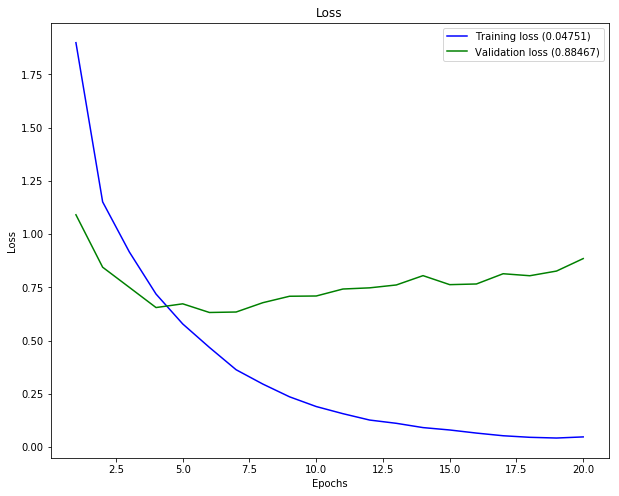

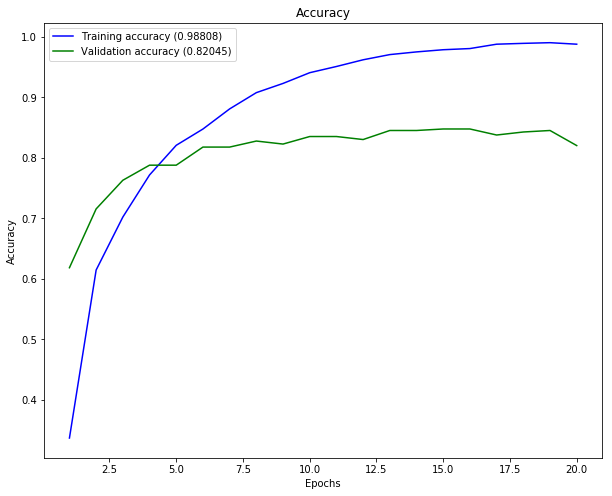

Confusion matrix
[[188  11   1  23   0   3   1   0]
 [  9  68   0   3   0   2   0   0]
 [  2   0   0   0   0   0   0   0]
 [ 14   1   0  57   0   1   0   0]
 [  1   0   0   0   0   0   0   0]
 [ 10   0   0   1   0  42   0   0]
 [  1   1   0   0   0   0   5   0]
 [  1   0   0   0   0   0   0   0]]
Test Accuracy: 0.807175


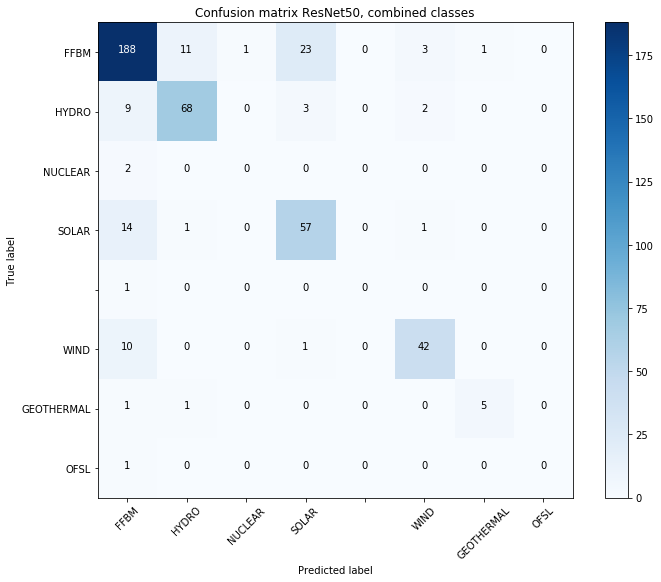

In [11]:
# Plot train and val accuracy & loss
plot_history(history)

# Make prediction on test set
y_test_pred = model.predict(x_test)
pred_class = np.argmax(y_test_pred, axis=-1)
label_class = np.argmax(y_test, axis=-1)

# Show confusion matrix
cnf_matrix = confusion_matrix(label_class, pred_class)
class_names = list(list(dict_id_flabel.values())) # list of all the labels
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix ResNet50, combined classes')

# Calculate test accuracy
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(label_class, pred_class)
print('Test Accuracy: %f' % test_acc)